## Topics



### 1. Problem Definition  
### 2. Exploratory Data Analysis (EDA)  
### 3. Text Preprocessing
### 4. Model Selection  
### 5. Evaluation
### 6. Push to the huggingface




-----



### **1. Problem Definition**

- **1.1. Identify the Problem**  
    The goal is to develop a machine learning model capable of distinguishing between text written by humans and text generated by AI models (e.g., ChatGPT, Gemini). This has applications in academic integrity, misinformation detection, content moderation, and authorship verification.

- **1.2. Define the Machine Learning Objective**  
    This is a **binary classification** task:
    - **Class 0**: Human-written text  
    - **Class 1**: AI-generated text  

- **1.3. Specify the Output**  
    The model should output either a class label (0 or 1) or a probability score indicating the likelihood that the input text is AI-generated.





--------

## Exploratory Data Analysis (EDA)  

Main tools

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 13.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from collections import Counter
import string
import re
import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from peft import LoraConfig, get_peft_model


import optuna
import kagglehub



Load the dataset according to your enviroment

In [3]:
import sys, os

if "google.colab" in sys.modules:
    shanegerami_ai_vs_human_text_path = kagglehub.dataset_download('shanegerami/ai-vs-human-text')
    df = pd.read_csv(os.path.join(shanegerami_ai_vs_human_text_path, 'AI_Human.csv'))
    print('Data source import complete.')


elif os.getenv("KAGGLE_KERNEL_RUN_TYPE"):
    df = pd.read_csv('/kaggle/input/ai-vs-human-text/AI_Human.csv')


Data source import complete.


In [4]:
df.head()

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


In [5]:
df.describe()

,generated
count,487235.000000
mean,0.372383
std,0.483440
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Number of AI generated texts vs human text

In [6]:
df['generated'].value_counts(normalize=True)


,proportion
generated,
0.0,0.627617
1.0,0.372383


Now, let's check the length of texts

In [7]:
df['text_length'] = df['text'].apply(lambda x: len(x.split()))
df['text_length'].describe()

,text_length
count,487235.000000
mean,393.096214
std,168.593328
min,0.000000
25%,278.000000
50%,363.000000
75%,471.000000
max,1668.000000


In [8]:
df['text_length'].head()

,text_length
0,584
1,462
2,744
3,686
4,871


Plot distribution of text lengths by label


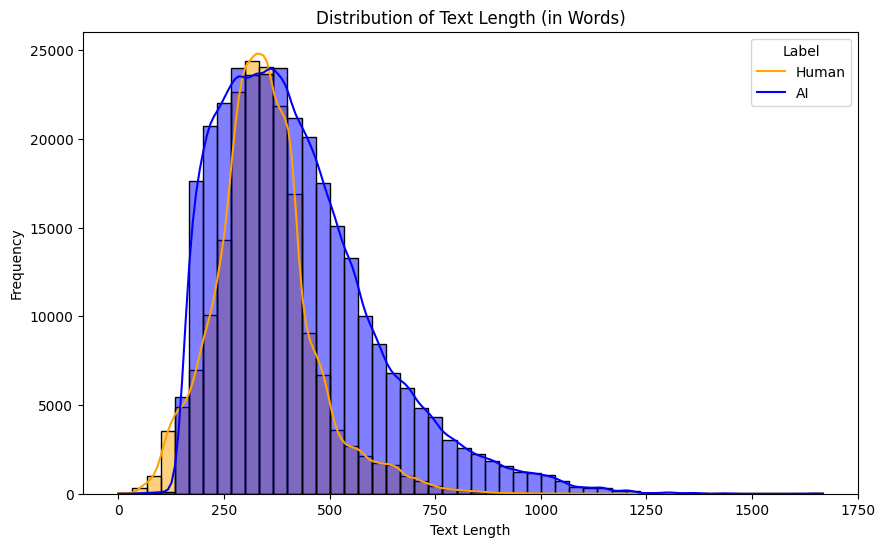

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', hue='generated', bins=50, kde=True, palette={0: 'blue', 1: 'orange'}, fill=True)
plt.title('Distribution of Text Length (in Words)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend(title='Label', labels=['Human', 'AI'])
plt.show()

As we can see, the text length distribution is different for human and AI generated texts. Human generated texts tend to be shorter, while AI generated texts tend to be longer. This could be due to the fact that human generated texts are more concise and to the point, while AI generated texts are more verbose and detailed.

Let's see the text richness in ai generated text and human ai generated text

In [10]:

def type_token_ratio(text):
    tokens = text.lower().split()
    return len(set(tokens)) / len(tokens) if len(tokens) > 0 else 0

df['ttr'] = df['text'].apply(type_token_ratio)

# Compare between classes
df.groupby('generated')['ttr'].describe()

,count,mean,std,min,25%,50%,75%,max
generated,,,,,,,,
0.0,305797.0,0.480593,0.083189,0.053957,0.424040,0.48105,0.537931,0.928571
1.0,181438.0,0.510901,0.093479,0.000000,0.444915,0.50000,0.569475,1.000000



- **AI Text (mean = 0.51)** is **slightly more lexically rich** than human text (mean = 0.48), suggesting more varied vocabulary.
- However, **overlapping ranges** indicate both can have diverse or repetitive language.

In [11]:
def count_punctuation(text):
    return sum(1 for char in text if char in string.punctuation)

df['punctuation_count'] = df['text'].apply(count_punctuation)

df.groupby('generated')['punctuation_count'].describe()

,count,mean,std,min,25%,50%,75%,max
generated,,,,,,,,
0.0,305797.0,48.996066,27.241608,0.0,30.0,44.0,62.0,388.0
1.0,181438.0,46.552089,22.428644,0.0,31.0,42.0,58.0,258.0



- **Human Text (mean = 49)** uses **slightly more punctuation** than AI text (mean = 46.5).
- The distribution shows **similar variability**, but some human texts are far more punctuated (max = 388 vs. 258).


Download the stop words in nltk

In [12]:
import nltk
nltk.download('stopwords')

from zipfile import ZipFile
file_loc = '/root/nltk_data/corpora/stopwords.zip'
with ZipFile(file_loc, 'r') as z:
  z.extractall('/root/nltk_data/corpora/')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
stop_words = set(stopwords.words('english'))

def stopword_ratio(text):
    tokens = text.lower().split()
    if len(tokens) == 0:
        return 0
    stop_count = sum(1 for token in tokens if token in stop_words)
    return stop_count / len(tokens)

df['stopword_ratio'] = df['text'].apply(stopword_ratio)

df.groupby('generated')['stopword_ratio'].describe()


,count,mean,std,min,25%,50%,75%,max
generated,,,,,,,,
0.0,305797.0,0.477323,0.052504,0.201373,0.444444,0.480000,0.512748,0.724696
1.0,181438.0,0.431636,0.061010,0.000000,0.393548,0.435821,0.474023,0.653846


- **Human Text (mean = 0.48)** has a **higher stopword ratio** than AI text (mean = 0.43).
- This suggests humans use **more natural filler words** like "the", "and", "is", which AI may underuse.


## 3. Text Preprocessing

Filter out and remove normalize text

In [14]:
df['text'] = df['text'].str.lower() # lower text
df['text'] = df['text'].str.strip().str.replace(r'\s+', ' ', regex=True) # strip the text
df['text'] = df['text'].str.translate(str.maketrans('', '', string.punctuation)) # remove puncituation

Remove Stopwords

In [15]:
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

Remove noise like (emails, urls)

In [16]:
def remove_noise(text):
    text = re.sub(r'http\S+|www\.\S+', '', text)      # URLs
    text = re.sub(r'\S+@\S+\.\S+', '', text)          # Emails
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)        # Hashtags
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)        # Mentions
    text = re.sub(r'\d+', '', text)                   # Numbers
    return ''.join(ch for ch in text if ch.isprintable())  # Non-printable
df['text'] = df['text'].apply(remove_noise)

Remove very short or very long text

Plot before removing

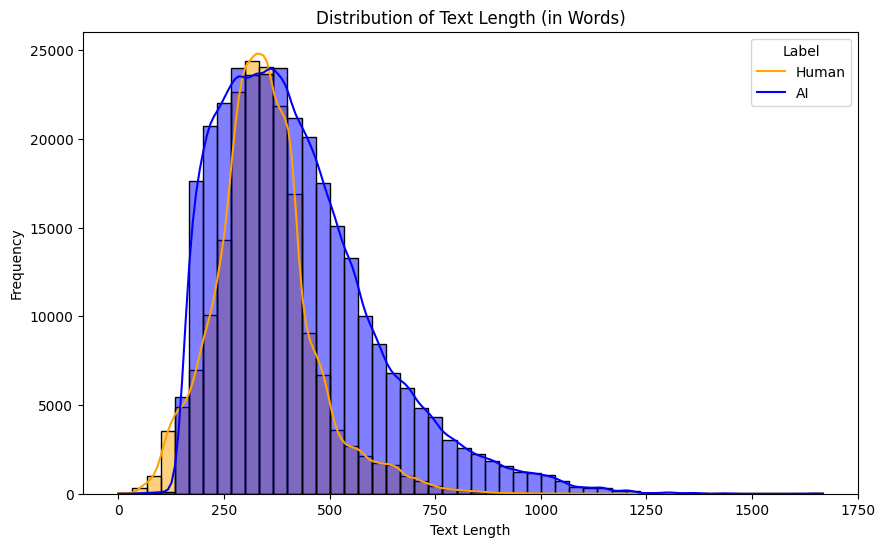

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', hue='generated', bins=50, kde=True, palette={0: 'blue', 1: 'orange'}, fill=True)
plt.title('Distribution of Text Length (in Words)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend(title='Label', labels=['Human', 'AI'])
plt.show()

we will ensure that there is no very long texts and no very short texts to make it easier for us to train the model.

In [18]:
human_min_words, human_max_words = df[df['generated'] == 0 ]['text_length'].quantile([.01, .99])
ai_min_words, ai_max_words = df[df['generated'] == 1 ]['text_length'].quantile([.01, .99])

print(human_min_words, human_max_words)
print(ai_min_words, ai_max_words)

160.0 1007.0
106.0 705.0


In [19]:
# Create masks for each class
human_mask = (df['generated'] == 0) & df['text_length'].between(human_min_words, human_max_words)
ai_mask    = (df['generated'] == 1) & df['text_length'].between(ai_min_words, ai_max_words)

# Combine masks to filter the DataFrame
df_filtered = df[human_mask | ai_mask].copy()

# Optional: reset index
df_filtered.reset_index(drop=True, inplace=True)

# Show resulting shapes and sample
print("Original dataset shape:", df.shape)
print("Filtered dataset shape:", df_filtered.shape)

df_filtered.head()
df = df.drop_duplicates(subset='text')

Original dataset shape: (487235, 6)
Filtered dataset shape: (477953, 6)


In [20]:
df_filtered.describe()

,generated,text_length,ttr,punctuation_count,stopword_ratio
count,477953.000000,477953.000000,477953.000000,477953.000000,477953.000000
mean,0.372210,389.670779,0.491375,47.698081,0.460188
std,0.483395,156.409502,0.086700,24.235193,0.059791
min,0.000000,106.000000,0.093023,0.000000,0.070632
25%,0.000000,279.000000,0.432373,30.000000,0.423656
50%,0.000000,362.000000,0.487179,43.000000,0.464986
75%,1.000000,468.000000,0.547401,60.000000,0.501312
max,1.000000,1007.000000,0.902985,290.000000,0.724696


In [21]:
df = df_filtered

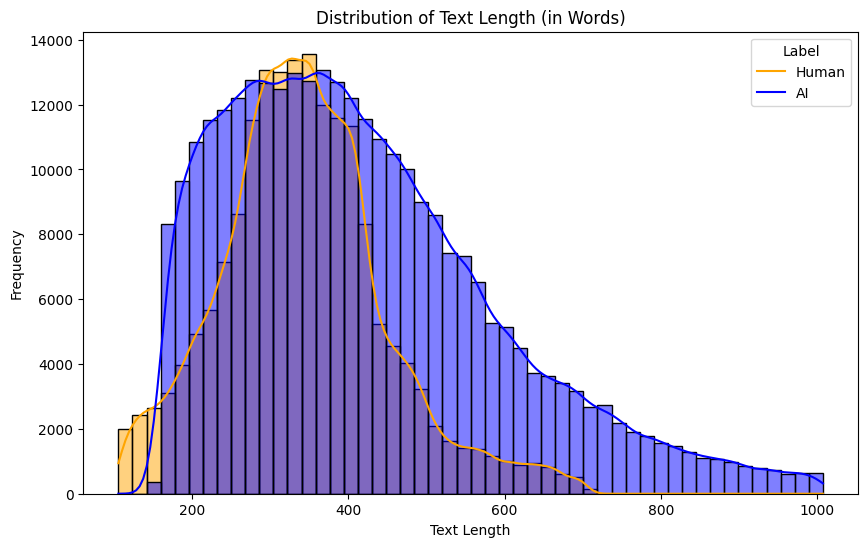

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', hue='generated', bins=50, kde=True, palette={0: 'blue', 1: 'orange'}, fill=True)
plt.title('Distribution of Text Length (in Words)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend(title='Label', labels=['Human', 'AI'])
plt.show()

In [23]:
import os
from datasets import load_dataset, DatasetDict, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [24]:
df

,text,generated,text_length,ttr,punctuation_count,stopword_ratio
0,cars cars around since became famous s henry f...,0.0,584,0.508562,75,0.421233
1,transportation large necessity countries world...,0.0,462,0.556277,64,0.422078
2,americas love affair vehicles seems cooling sa...,0.0,744,0.479839,101,0.440860
3,often ride car drive one motor vehicle work st...,0.0,686,0.561224,124,0.450437
4,cars wonderful thing perhaps one worlds greate...,0.0,871,0.420207,110,0.436280
...,...,...,...,...,...,...
477948,tie face mars really big misunderstanding stro...,0.0,192,0.546875,16,0.463542
477949,whole purpose democracy create government refl...,0.0,385,0.522078,46,0.483117
477950,firmly believe governments worldwide take imme...,1.0,360,0.605556,58,0.369444
477951,dfnt agree decision lft ff kids may nft want t...,0.0,339,0.412979,24,0.395280


We’ll train the model using only a small subset of the data—reserving the remainder to evaluate its performance after fine-tuning.


In [35]:
train_df, temp_df = train_test_split(df, test_size=0.9, stratify=df['generated'])

In [36]:
temp_df.shape

(430158, 6)

In [39]:
test_df, validation_df = train_test_split(temp_df, test_size=0.05, stratify=temp_df['generated'])


In [40]:
train_df.shape, validation_df.shape, test_df.shape

((47795, 6), (21508, 6), (408650, 6))

In [92]:
test_size = 20000

In [93]:
datasets = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(validation_df),
    "test": Dataset.from_pandas(test_df[:test_size]),
})

In [94]:
from datasets import Value


In [95]:
datasets = datasets.rename_column("generated", "labels")

In [96]:
datasets = datasets.cast_column("labels", Value("int8"))

Casting the dataset:   0%|          | 0/47795 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/21508 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/20000 [00:00<?, ? examples/s]

## 4. Model Selection

We will use `"distilbert/distilroberta-base"` as our classification model and fine-tune it on a small subset of the data.


In [45]:
MODEL_NAME = "distilbert/distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
from peft import LoraConfig, TaskType

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["query", "key"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS # task type
)

model = get_peft_model(model, lora_config)

Unfreeze the classifier head to allow it to be trained.

In [47]:
for param in model.classifier.parameters():
    param.requires_grad = True

In [97]:

def tokenize_function(batch):
    return tokenizer(batch["text"], truncation=True)

apply the tokenization to the dataset.

In [98]:
datasets = datasets.map(tokenize_function, batched=True, batch_size=10000)


Map:   0%|          | 0/47795 [00:00<?, ? examples/s]

Map:   0%|          | 0/21508 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

custom function for metrics calculations.

In [80]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

In [51]:
data_collator = DataCollatorWithPadding(tokenizer)


Create the training arguments, we will the lora model train for 2 epochs and with the following parameters.


* `output_dir`: folder to save model and checkpoints
* `eval_strategy`: evaluate every few steps
* `eval_steps`: how often to evaluate (every 1000 steps)
* `save_strategy`: save checkpoints every few steps
* `save_steps`: how often to save (every 1000 steps)
* `logging_strategy`: log training info every few steps
* `logging_steps`: how often to log (every 1000 steps)
* `learning_rate`: speed of learning
* `per_device_train_batch_size`: batch size per GPU for training
* `per_device_eval_batch_size`: batch size per GPU for eval
* `num_train_epochs`: number of full passes through the data
* `weight_decay`: helps prevent overfitting
* `load_best_model_at_end`: keep best model based on metric
* `metric_for_best_model`: metric used to pick best model (F1)
* `report_to`: disables external logging (like WandB)



In [60]:
training_args = TrainingArguments(
    output_dir="model",
    eval_strategy="steps",
    eval_steps=1000,         # evaluate every 1000 steps
    save_strategy="steps",
    save_steps=1000,         # save every 1000 steps
    logging_strategy="steps",
    logging_steps=1000,
    learning_rate=2e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=256,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",
)

Create the trainer.

In [61]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets["train"],
    eval_dataset=datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

<ipython-input-61-e1db6cc2dac4>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [62]:
total_trainable = sum(param.numel()
                      for _, param in model.named_parameters()
                      if param.requires_grad)
print(f"\nTotal trainable parameters: {total_trainable:,}")



Total trainable parameters: 1,331,716


empty the cuda cache before training.

In [99]:
import torch
torch.cuda.empty_cache()

In [64]:
trainer.train()


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1000,0.061500,0.056078,0.980891,0.963388,0.986134,0.974628
2000,0.046200,0.044987,0.987958,0.982677,0.985009,0.983842


TrainOutput(global_step=2988, training_loss=0.04876313854253276, metrics={'train_runtime': 3825.3887, 'train_samples_per_second': 24.988, 'train_steps_per_second': 0.781, 'total_flos': 1.1653032603057624e+16, 'train_loss': 0.04876313854253276, 'epoch': 2.0})

### 5. Evaluation


run the compute_metrics on the test dataset.

In [100]:
datasets["test"]

Dataset({
    features: ['text', 'labels', 'text_length', 'ttr', 'punctuation_count', 'stopword_ratio', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 20000
})

In [102]:
test_metrics = trainer.evaluate(
    eval_dataset=datasets["test"],
    metric_key_prefix="test"
)

print("Test set metrics:")
for key, value in test_metrics.items():
    print(f"  {key}: {value:.4f}")


Test set metrics:
  test_loss: 0.0449
  test_accuracy: 0.9875
  test_precision: 0.9798
  test_recall: 0.9863
  test_f1: 0.9831
  test_runtime: 290.1780
  test_samples_per_second: 68.9230
  test_steps_per_second: 0.2720
  epoch: 2.0000


### 6. Push to the huggingface

In [104]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
The token `fine-tuning` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate wh

In [105]:
username = 'DeepActionPotential'

In [109]:
# Merge LoRA weights into the base model
merged_model = model.merge_and_unload()

# Push model
merged_model.push_to_hub(f"{username}/distilroberta-classifier-finetuned")


model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/DeepActionPotential/distilroberta-classifier-finetuned/commit/dc9d8062178ccb5443d49b19e8bcd701c13b0869', commit_message='Upload RobertaForSequenceClassification', commit_description='', oid='dc9d8062178ccb5443d49b19e8bcd701c13b0869', pr_url=None, repo_url=RepoUrl('https://huggingface.co/DeepActionPotential/distilroberta-classifier-finetuned', endpoint='https://huggingface.co', repo_type='model', repo_id='DeepActionPotential/distilroberta-classifier-finetuned'), pr_revision=None, pr_num=None)

In [110]:
# Push tokenizer
tokenizer.push_to_hub(f"{username}/distilroberta-classifier-finetuned")

CommitInfo(commit_url='https://huggingface.co/DeepActionPotential/distilroberta-classifier-finetuned/commit/8cbb3f6fc80cb7fe1ff01c43d3677666639821af', commit_message='Upload tokenizer', commit_description='', oid='8cbb3f6fc80cb7fe1ff01c43d3677666639821af', pr_url=None, repo_url=RepoUrl('https://huggingface.co/DeepActionPotential/distilroberta-classifier-finetuned', endpoint='https://huggingface.co', repo_type='model', repo_id='DeepActionPotential/distilroberta-classifier-finetuned'), pr_revision=None, pr_num=None)

**THANK YOU**
